## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("dataset/Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value']=df_comp.ftse

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [5]:
import warnings
warnings.filterwarnings("ignore")

## The LLR Test

In [6]:
# can only be used to compare the nested one
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [7]:
df['returns'] = df.market_value.pct_change(1)*100

## ARMA(1,1)

In [9]:
# positive coefficient for the AR(1) means that the positive change and negative change usually are consecutive, meaning that the surge and decline usually continue to the next day
# negative coefficient for MA(1) can be interpretted as ensuring we don't get a "fool in the shower" type of error, to elaborate, we want to prevent our targets for moving before we've accounted for them
model_1 = ARMA(df.returns[1:], order=(1,1))
result_1 = model_1.fit()
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood               -7916.500
Method:                       css-mle   S.D. of innovations              1.171
Date:                Wed, 10 Mar 2021   AIC                          15841.000
Time:                        13:26:39   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.446      0.148      -0.007       0.045
ar.L1.returns     0.7649      0.067     11.349      0.000       0.633       0.897
ma.L1.returns    -0.8141      0.061    -13.406      0.000      -0.933      -0.695
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3074           +0.0000j            1.3074            0.0000
MA.1            1.2284           +0.0000j            1.2284            0.0000
-----------------------------------------------------------------------------
"""

In [10]:
model_ar_1 = ARMA(df.returns[1:], order=(1,0))
model_ma_1 = ARMA(df.returns[1:], order=(0,1))

In [11]:
# since order for ARMA is 1+1=2, so the DF here is still 1 (2-1)
print('LLR Test with AR:' , str(LLR_test(model_ar_1, model_1)))
print('LLR Test with MA:' , str(LLR_test(model_ma_1, model_1)))

LLR Test with AR: 0.0
LLR Test with MA: 0.0


## Higher-Lag ARMA Models

In [12]:
# from previous analysis we know that AR(6) and MA(8) are the besst model respectively, but if we fit ARMA(8,6), it would take too long to run, and a lot of coefficients would cancel each out
# This means that ARMA(8,6) is over complicated. Starting from ARMA(3,3) is a reasonable idea
model_33 = ARMA(df.returns[1:], order=(3,3))
result_33 = model_33.fit()
result_33.summary()
# the result shows that 1st lags for AR/MA are not significant, we can reduce the ARMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 3)   Log Likelihood               -7893.515
Method:                       css-mle   S.D. of innovations              1.166
Date:                Wed, 10 Mar 2021   AIC                          15803.030
Time:                        13:52:50   BIC                          15855.199
Sample:                    01-10-1994   HQIC                         15821.310
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.395      0.163      -0.008       0.045
ar.L1.returns    -0.1898      0.104     -1.827      0.068      -0.393       0.014
ar.L2.returns    -0.2942      0.087     -3.389      0.001      -0.464      -0.124
ar.L3.returns     0.4459      0.138      3.225      0.001       0.175       0.717
ma.L1.returns     0.1707      0.099      1.726      0.084      -0.023       0.365
ma.L2.returns     0.2277      0.084      2.701      0.007       0.062       0.393
ma.L3.returns    -0.5432      0.127     -4.270      0.000      -0.793      -0.294
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5168           -1.0283j            1.1508           -0.3241
AR.2           -0.5168           +1.0283j            1.1508            0.3241
AR.3            1.6932           -0.0000j            1.6932           -0.0000
MA.1           -0.5286           -0.9835j            1.1166           -0.3285
MA.2           -0.5286           +0.9835j            1.1166            0.3285
MA.3            1.4764           -0.0000j            1.4764           -0.0000
-----------------------------------------------------------------------------
"""

In [13]:
print('LLR Test with ARMA(1,1):' , str(LLR_test(model_1, model_33, DF=4)))

LLR Test with ARMA(1,1): 0.0


In [14]:
# start from ARMA with DF=5
model_32 = ARMA(df.returns[1:], order=(3,2))
result_32 = model_32.fit()
result_32.summary()
# all coefficients are significant, except the constant. But it's ok, as in an efficient market, the return should be 0
# so it's ok it's not significantly different from 0
# the coefficient is getting smaller, the further back in time we go, the less relevant errors and values become
# it suggest calibration efforts
# negative coefficient for values is to pull it back to zero, efficient market
# positive coefficient for errors is to pull it back to zero, efficient market as well, as error = true-predicted, if true > predicted, error = +, coefficient*error=+, predicted return increase, thus lower the next error 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 2)   Log Likelihood               -7895.747
Method:                       css-mle   S.D. of innovations              1.166
Date:                Wed, 10 Mar 2021   AIC                          15805.495
Time:                        13:56:31   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.251      0.211      -0.011       0.048
ar.L1.returns    -0.6785      0.087     -7.799      0.000      -0.849      -0.508
ar.L2.returns    -0.5088      0.139     -3.670      0.000      -0.780      -0.237
ar.L3.returns    -0.1141      0.015     -7.655      0.000      -0.143      -0.085
ma.L1.returns     0.6568      0.087      7.536      0.000       0.486       0.828
ma.L2.returns     0.4474      0.141      3.175      0.001       0.171       0.724
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4929           -1.5101j            1.5885           -0.3002
AR.2           -0.4929           +1.5101j            1.5885            0.3002
AR.3           -3.4748           -0.0000j            3.4748           -0.5000
MA.1           -0.7340           -1.3025j            1.4951           -0.3317
MA.2           -0.7340           +1.3025j            1.4951            0.3317
-----------------------------------------------------------------------------
"""

In [15]:
# one of the coefficient is still not significant, so we should not choose this model
model_23 = ARMA(df.returns[1:], order=(2,3))
result_23 = model_23.fit()
result_23.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 3)   Log Likelihood               -7895.587
Method:                       css-mle   S.D. of innovations              1.166
Date:                Wed, 10 Mar 2021   AIC                          15805.174
Time:                        17:11:40   BIC                          15850.823
Sample:                    01-10-1994   HQIC                         15821.170
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.276      0.202      -0.010       0.048
ar.L1.returns    -0.5605      0.090     -6.245      0.000      -0.736      -0.385
ar.L2.returns    -0.4187      0.193     -2.172      0.030      -0.797      -0.041
ma.L1.returns     0.5378      0.090      6.000      0.000       0.362       0.714
ma.L2.returns     0.3540      0.195      1.818      0.069      -0.028       0.736
ma.L3.returns    -0.1158      0.016     -7.369      0.000      -0.147      -0.085
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6694           -1.3930j            1.5455           -0.3213
AR.2           -0.6694           +1.3930j            1.5455            0.3213
MA.1           -0.7270           -1.1772j            1.3836           -0.3381
MA.2           -0.7270           +1.1772j            1.3836            0.3381
MA.3            4.5096           -0.0000j            4.5096           -0.0000
-----------------------------------------------------------------------------
"""

In [16]:
model_31 = ARMA(df.returns[1:], order=(3,1))
result_31 = model_31.fit()
result_31.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 1)   Log Likelihood               -7899.072
Method:                       css-mle   S.D. of innovations              1.167
Date:                Wed, 10 Mar 2021   AIC                          15810.144
Time:                        17:13:38   BIC                          15849.271
Sample:                    01-10-1994   HQIC                         15823.855
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.298      0.194      -0.010       0.047
ar.L1.returns    -0.5077      0.088     -5.769      0.000      -0.680      -0.335
ar.L2.returns    -0.0638      0.016     -4.023      0.000      -0.095      -0.033
ar.L3.returns    -0.1102      0.014     -7.850      0.000      -0.138      -0.083
ma.L1.returns     0.4839      0.088      5.500      0.000       0.311       0.656
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5095           -0.0000j            1.5095           -0.5000
AR.2            0.4653           -2.4076j            2.4521           -0.2196
AR.3            0.4653           +2.4076j            2.4521            0.2196
MA.1           -2.0668           +0.0000j            2.0668            0.5000
-----------------------------------------------------------------------------
"""

In [17]:
# always put the simplier model first otherwise the LLR test will always return 1
print('LLR Test with ARMA(3,1):' , str(LLR_test(model_31, model_32)))

LLR Test with ARMA(3,1): 0.01


In [18]:
# 2nd lags for error and value are not significant, which we can believe that ARMA(2,1) and ARMA(1,2) would outperform ARMA(2,2)
model_22 = ARMA(df.returns[1:], order=(2,2))
result_22 = model_22.fit()
result_22.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 2)   Log Likelihood               -7913.223
Method:                       css-mle   S.D. of innovations              1.170
Date:                Wed, 10 Mar 2021   AIC                          15838.446
Time:                        17:16:02   BIC                          15877.573
Sample:                    01-10-1994   HQIC                         15852.156
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.394      0.163      -0.008       0.045
ar.L1.returns     0.7820      0.238      3.284      0.001       0.315       1.249
ar.L2.returns    -0.1563      0.177     -0.884      0.377      -0.503       0.190
ma.L1.returns    -0.8105      0.239     -3.388      0.001      -1.279      -0.342
ma.L2.returns     0.1177      0.187      0.628      0.530      -0.250       0.485
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5017           -0.3738j            2.5295           -0.0236
AR.2            2.5017           +0.3738j            2.5295            0.0236
MA.1            1.6107           +0.0000j            1.6107            0.0000
MA.2            5.2739           +0.0000j            5.2739            0.0000
-----------------------------------------------------------------------------
"""

In [19]:
# ARMA(1,3) is not nested in ARMA(3,2). All AR(Q) is nested in AR(Q+1) model
# so the LLR test will become void
# we should use aic, bic to manually compare the two models
model_13 = ARMA(df.returns[1:], order=(1,3))
result_13 = model_13.fit()
result_13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 3)   Log Likelihood               -7896.838
Method:                       css-mle   S.D. of innovations              1.167
Date:                Wed, 10 Mar 2021   AIC                          15805.676
Time:                        17:18:13   BIC                          15844.803
Sample:                    01-10-1994   HQIC                         15819.386
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.332      0.183      -0.009       0.047
ar.L1.returns    -0.4699      0.096     -4.901      0.000      -0.658      -0.282
ma.L1.returns     0.4474      0.095      4.691      0.000       0.260       0.634
ma.L2.returns    -0.0637      0.015     -4.113      0.000      -0.094      -0.033
ma.L3.returns    -0.1182      0.014     -8.200      0.000      -0.146      -0.090
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1282           +0.0000j            2.1282            0.5000
MA.1           -1.4882           -1.1206j            1.8629           -0.3973
MA.2           -1.4882           +1.1206j            1.8629            0.3973
MA.3            2.4376           -0.0000j            2.4376           -0.0000
-----------------------------------------------------------------------------
"""

In [22]:
# should become void
print('LLR Test with ARMA(1,3):' , str(LLR_test(model_13, model_32)))

LLR Test with ARMA(1,3): 0.14


In [23]:
# we'll choose ARMA(3,2) as it provide loer AIC
print(result_32.llf, result_32.aic)
print(result_13.llf, result_13.aic)

-7895.747458514442 15805.494917028884
-7896.837893753025 15805.67578750605


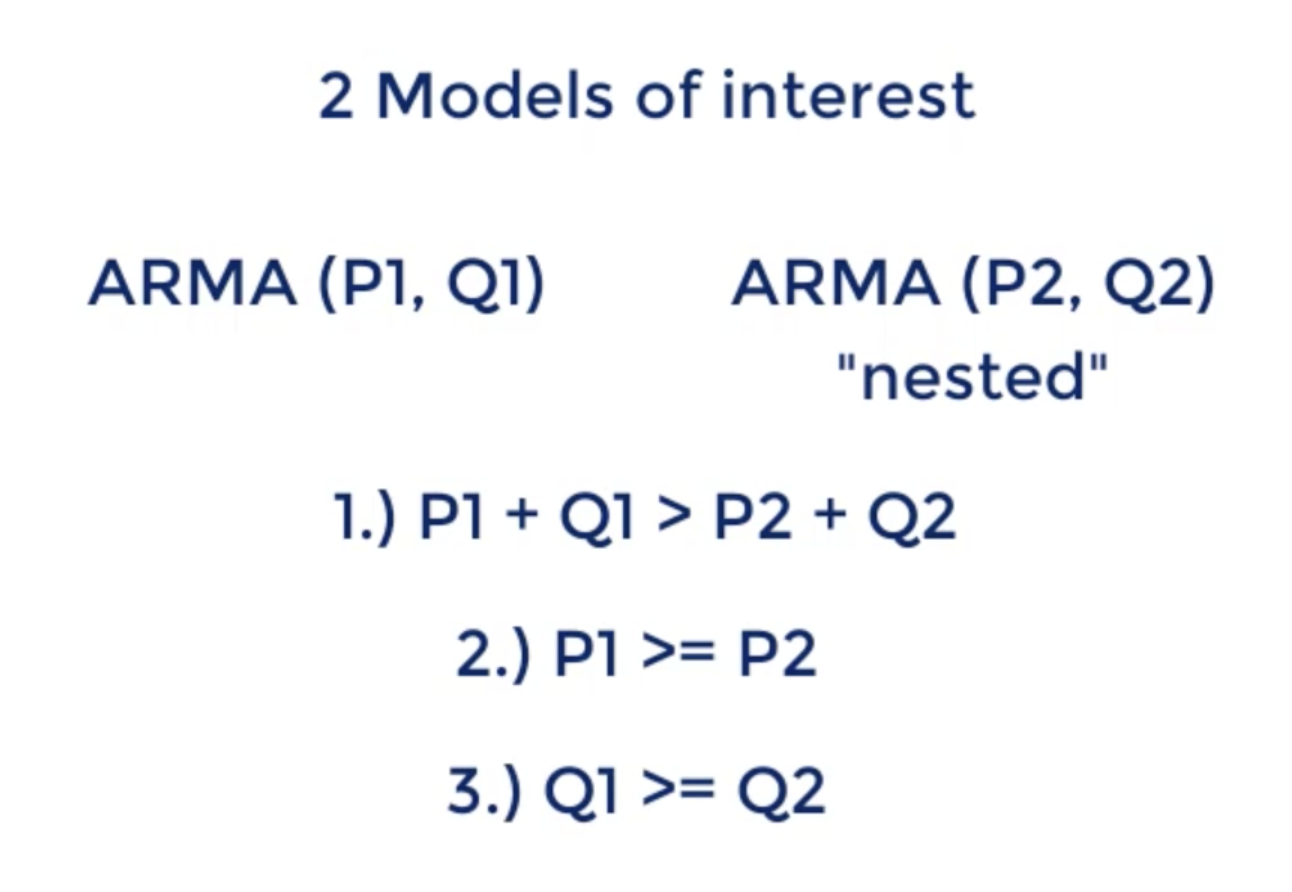

## Residuals for Returns

In [24]:
df['residual_re'] = result_32.resid

Text(0.5, 1.0, 'Residual of Returns')

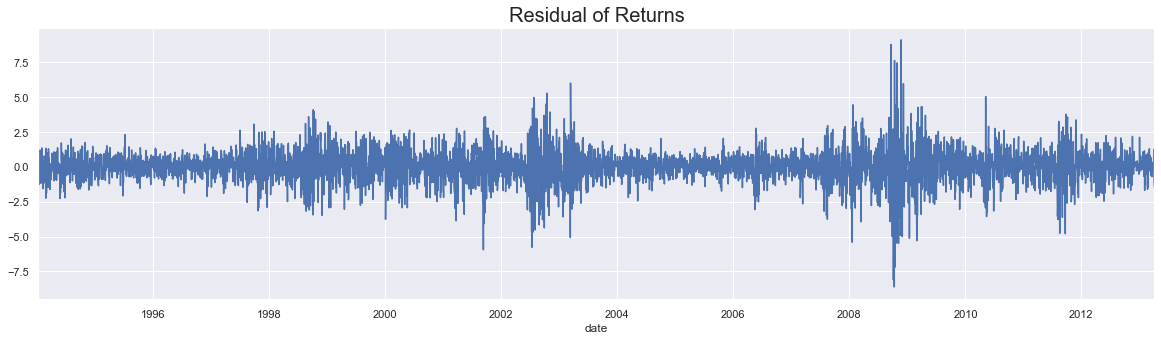

In [27]:
df.residual_re[1:].plot(figsize=(20,5))
plt.title('Residual of Returns', size=20)

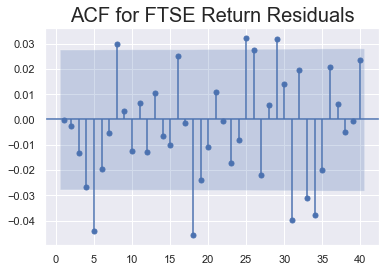

In [28]:
# there are more significant lags than AR/MA models
# because 5th lags is not included in the model and it's significant, we should change the model and include it
sgt.plot_acf(df.residual_re[1:], zero=False, lags=40)
plt.title('ACF for FTSE Return Residuals', size=20)
plt.show()

## Reevaluating Model Selection

In [29]:
# only three of them are significant, (5,5) is too redundant
model_55 = ARMA(df.returns[1:], order=(5,5))
result_55 = model_55.fit()
result_55.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 5)   Log Likelihood               -7882.160
Method:                       css-mle   S.D. of innovations              1.163
Date:                Wed, 10 Mar 2021   AIC                          15788.321
Time:                        17:31:26   BIC                          15866.575
Sample:                    01-10-1994   HQIC                         15815.742
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.402      0.161      -0.008       0.045
ar.L1.returns    -0.0684      0.140     -0.490      0.624      -0.342       0.205
ar.L2.returns    -0.6722      0.146     -4.603      0.000      -0.958      -0.386
ar.L3.returns    -0.1152      0.141     -0.817      0.414      -0.392       0.161
ar.L4.returns     0.1779      0.129      1.381      0.167      -0.075       0.430
ar.L5.returns     0.1215      0.107      1.132      0.258      -0.089       0.332
ma.L1.returns     0.0443      0.138      0.322      0.748      -0.226       0.314
ma.L2.returns     0.6223      0.144      4.321      0.000       0.340       0.905
ma.L3.returns     0.0107      0.136      0.079      0.937      -0.256       0.277
ma.L4.returns    -0.1753      0.122     -1.436      0.151      -0.415       0.064
ma.L5.returns    -0.2240      0.104     -2.148      0.032      -0.428      -0.020
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0870           -1.0364j            1.0401           -0.2367
AR.2            0.0870           +1.0364j            1.0401            0.2367
AR.3            1.7715           -0.0000j            1.7715           -0.0000
AR.4           -1.7050           -1.1784j            2.0726           -0.4038
AR.5           -1.7050           +1.1784j            2.0726            0.4038
MA.1            0.1033           -1.0434j            1.0485           -0.2343
MA.2            0.1033           +1.0434j            1.0485            0.2343
MA.3            1.4855           -0.0000j            1.4855           -0.0000
MA.4           -1.2373           -1.0965j            1.6532           -0.3846
MA.5           -1.2373           +1.0965j            1.6532            0.3846
-----------------------------------------------------------------------------
"""

In [30]:
model_51 = ARMA(df.returns[1:], order=(5,1))
result_51 = model_51.fit()
result_51.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 1)   Log Likelihood               -7889.311
Method:                       css-mle   S.D. of innovations              1.165
Date:                Wed, 10 Mar 2021   AIC                          15794.623
Time:                        17:33:10   BIC                          15846.792
Sample:                    01-10-1994   HQIC                         15812.903
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.407      0.159      -0.007       0.045
ar.L1.returns     0.3440      0.131      2.624      0.009       0.087       0.601
ar.L2.returns    -0.0458      0.015     -3.005      0.003      -0.076      -0.016
ar.L3.returns    -0.0652      0.016     -4.010      0.000      -0.097      -0.033
ar.L4.returns     0.0741      0.018      4.068      0.000       0.038       0.110
ar.L5.returns    -0.0813      0.014     -5.688      0.000      -0.109      -0.053
ma.L1.returns    -0.3673      0.131     -2.801      0.005      -0.624      -0.110
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6158           -0.0000j            1.6158           -0.5000
AR.2            1.3793           -0.8613j            1.6261           -0.0888
AR.3            1.3793           +0.8613j            1.6261            0.0888
AR.4           -0.1156           -1.6929j            1.6968           -0.2608
AR.5           -0.1156           +1.6929j            1.6968            0.2608
MA.1            2.7223           +0.0000j            2.7223            0.0000
-----------------------------------------------------------------------------
"""

In [31]:
model_15 = ARMA(df.returns[1:], order=(1,5))
result_15 = model_15.fit()
result_15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 5)   Log Likelihood               -7890.973
Method:                       css-mle   S.D. of innovations              1.165
Date:                Wed, 10 Mar 2021   AIC                          15797.947
Time:                        17:33:32   BIC                          15850.116
Sample:                    01-10-1994   HQIC                         15816.228
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.419      0.156      -0.007       0.045
ar.L1.returns     0.3285      0.152      2.159      0.031       0.030       0.627
ma.L1.returns    -0.3534      0.152     -2.332      0.020      -0.650      -0.056
ma.L2.returns    -0.0404      0.015     -2.624      0.009      -0.071      -0.010
ma.L3.returns    -0.0679      0.017     -4.022      0.000      -0.101      -0.035
ma.L4.returns     0.0742      0.020      3.771      0.000       0.036       0.113
ma.L5.returns    -0.0683      0.015     -4.660      0.000      -0.097      -0.040
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.0443           +0.0000j            3.0443            0.0000
MA.1           -1.1897           -1.1548j            1.6580           -0.3774
MA.2           -1.1897           +1.1548j            1.6580            0.3774
MA.3            1.5041           -0.0000j            1.5041           -0.0000
MA.4            0.9809           -1.6057j            1.8815           -0.1627
MA.5            0.9809           +1.6057j            1.8815            0.1627
-----------------------------------------------------------------------------
"""

In [32]:
print(result_51.llf, result_51.aic)
print(result_15.llf, result_15.aic)

-7889.3112829460715 15794.622565892143
-7890.973460209672 15797.946920419345


In [33]:
# ARMA(5,1) is the best model! because ARMA doen't have a graph to help judge the lags to be included, we should always do the residual test
# compared to AR use PACF and MA use ACF
print(result_51.llf, result_51.aic)
print(result_32.llf, result_32.aic)

-7889.3112829460715 15794.622565892143
-7895.747458514442 15805.494917028884


## Residuals for the New Model

In [34]:
df['residual_re2'] = result_51.resid

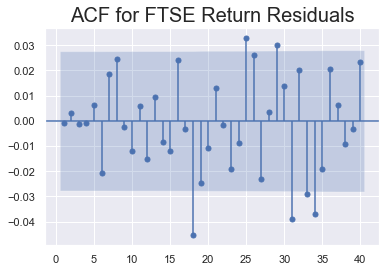

In [35]:
# we shouldn't increase more lags because their coefficient should be smaller, and it will also overfit
sgt.plot_acf(df.residual_re2[1:], zero=False, lags=40)
plt.title('ACF for FTSE Return Residuals', size=20)
plt.show()

## ARMA Models for Prices

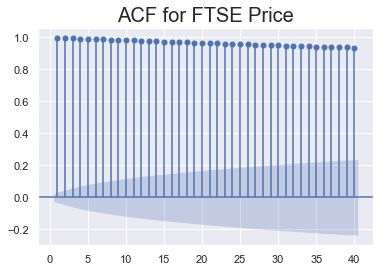

In [36]:
sgt.plot_acf(df.market_value, zero=False, lags=40)
plt.title('ACF for FTSE Price', size=20)
plt.show()

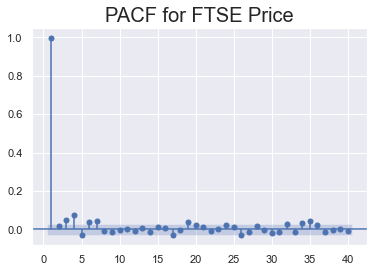

In [37]:
sgt.plot_pacf(df.market_value, zero=False, lags=40, alpha=0.05, method=('ols'))
plt.title('PACF for FTSE Price', size=20)
plt.show()

In [38]:
model_11 = ARMA(df.market_value, order=(1,1))
result_11 = model_11.fit()
result_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 1)   Log Likelihood              -27621.789
Method:                       css-mle   S.D. of innovations             59.248
Date:                Wed, 10 Mar 2021   AIC                          55251.579
Time:                        17:44:32   BIC                          55277.664
Sample:                    01-07-1994   HQIC                         55260.719
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6412    496.816     10.245      0.000    4115.900    6063.382
ar.L1.market_value     0.9985      0.001   1323.207      0.000       0.997       1.000
ma.L1.market_value    -0.0190      0.015     -1.274      0.203      -0.048       0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
MA.1           52.5194           +0.0000j           52.5194            0.0000
-----------------------------------------------------------------------------
"""

In [39]:
df['residual'] = result_11.resid

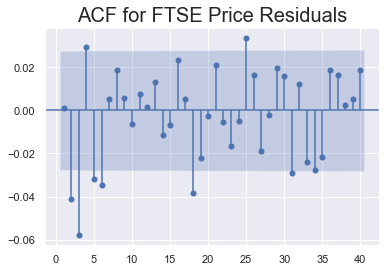

In [40]:
# 6th lags is significant, should probably include it
sgt.plot_acf(df.residual, zero=False, lags=40)
plt.title('ACF for FTSE Price Residuals', size=20)
plt.show()

In [41]:
# induce stationarity: change it to return, a stationary data
# choose a different model order: should avoid doing so, because we want to ARMA(6,6) model
# pass your own start_paramsL: is what we will do here
model_66 = ARMA(df.market_value, order=(6,6))
result_66 = model_66.fit()
result_66.summary()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [43]:
model_66 = ARMA(df.market_value, order=(6,6))
result_66 = model_66.fit(start_ar_lags=11)
result_66.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 6)   Log Likelihood              -27587.932
Method:                       css-mle   S.D. of innovations             58.849
Date:                Wed, 10 Mar 2021   AIC                          55203.864
Time:                        17:49:49   BIC                          55295.164
Sample:                    01-07-1994   HQIC                         55235.856
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6502    567.914      8.962      0.000    3976.560    6202.740
ar.L1.market_value     1.9278      0.032     59.945      0.000       1.865       1.991
ar.L2.market_value    -1.7362      0.040    -43.382      0.000      -1.815      -1.658
ar.L3.market_value     1.2678      0.034     36.809      0.000       1.200       1.335
ar.L4.market_value    -0.2376      0.157     -1.510      0.131      -0.546       0.071
ar.L5.market_value    -0.4062      0.165     -2.468      0.014      -0.729      -0.084
ar.L6.market_value     0.1840      0.049      3.769      0.000       0.088       0.280
ma.L1.market_value    -0.9489      0.035    -27.052      0.000      -1.018      -0.880
ma.L2.market_value     0.7800      0.032     24.186      0.000       0.717       0.843
ma.L3.market_value    -0.5086      0.031    -16.329      0.000      -0.570      -0.448
ma.L4.market_value    -0.1560      0.158     -0.987      0.324      -0.466       0.154
ma.L5.market_value     0.0953      0.057      1.681      0.093      -0.016       0.206
ma.L6.market_value     0.0670      0.024      2.809      0.005       0.020       0.114
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0856           -1.0503j            1.0538           -0.2371
AR.2            0.0856           +1.0503j            1.0538            0.2371
AR.3           -2.0257           -0.0000j            2.0257           -0.5000
AR.4            1.0011           -0.0000j            1.0011           -0.0000
AR.5            1.5303           -0.2671j            1.5535           -0.0275
AR.6            1.5303           +0.2671j            1.5535            0.0275
MA.1            0.1028           -1.0613j            1.0662           -0.2346
MA.2            0.1028           +1.0613j            1.0662            0.2346
MA.3            1.3621           -0.2796j            1.3905           -0.0322
MA.4            1.3621           +0.2796j            1.3905            0.0322
MA.5           -2.1757           -1.4338j            2.6057           -0.4073
MA.6           -2.1757           +1.4338j            2.6057            0.4073
-----------------------------------------------------------------------------
"""

In [45]:
model_56 = ARMA(df.market_value, order=(5,6))
result_56 = model_56.fit(start_ar_lags=7)
result_56.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(5, 6)   Log Likelihood              -27587.863
Method:                       css-mle   S.D. of innovations             58.849
Date:                Wed, 10 Mar 2021   AIC                          55201.726
Time:                        17:51:29   BIC                          55286.504
Sample:                    01-07-1994   HQIC                         55231.433
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6481    580.828      8.763      0.000    3951.246    6228.051
ar.L1.market_value     1.3583      0.178      7.647      0.000       1.010       1.706
ar.L2.market_value    -1.1288      0.237     -4.757      0.000      -1.594      -0.664
ar.L3.market_value     0.9146      0.229      3.997      0.000       0.466       1.363
ar.L4.market_value     0.0160      0.204      0.078      0.937      -0.383       0.415
ar.L5.market_value    -0.1613      0.119     -1.352      0.176      -0.395       0.073
ma.L1.market_value    -0.3795      0.178     -2.130      0.033      -0.729      -0.030
ma.L2.market_value     0.7293      0.125      5.829      0.000       0.484       0.975
ma.L3.market_value    -0.2197      0.153     -1.436      0.151      -0.520       0.080
ma.L4.market_value    -0.1387      0.114     -1.215      0.224      -0.362       0.085
ma.L5.market_value    -0.0879      0.017     -5.325      0.000      -0.120      -0.056
ma.L6.market_value     0.0265      0.024      1.128      0.259      -0.020       0.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0917           -1.0418j            1.0459           -0.2360
AR.2            0.0917           +1.0418j            1.0459            0.2360
AR.3            1.0010           -0.0000j            1.0010           -0.0000
AR.4            1.8982           -0.0000j            1.8982           -0.0000
AR.5           -2.9835           -0.0000j            2.9835           -0.5000
MA.1            0.1071           -1.0487j            1.0542           -0.2338
MA.2            0.1071           +1.0487j            1.0542            0.2338
MA.3           -1.5354           -1.5156j            2.1574           -0.3760
MA.4           -1.5354           +1.5156j            2.1574            0.3760
MA.5            1.5919           -0.0000j            1.5919           -0.0000
MA.6            4.5798           -0.0000j            4.5798           -0.0000
-----------------------------------------------------------------------------
"""

In [44]:
model_61 = ARMA(df.market_value, order=(6,1))
result_61 = model_61.fit(start_ar_lags=7)
result_61.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 1)   Log Likelihood              -27594.195
Method:                       css-mle   S.D. of innovations             58.923
Date:                Wed, 10 Mar 2021   AIC                          55206.389
Time:                        17:51:25   BIC                          55265.082
Sample:                    01-07-1994   HQIC                         55226.956
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6423    586.431      8.679      0.000    3940.260    6239.025
ar.L1.market_value     1.3921      0.058     23.924      0.000       1.278       1.506
ar.L2.market_value    -0.4369      0.059     -7.398      0.000      -0.553      -0.321
ar.L3.market_value    -0.0101      0.025     -0.409      0.683      -0.059       0.038
ar.L4.market_value     0.1126      0.025      4.527      0.000       0.064       0.161
ar.L5.market_value    -0.1158      0.025     -4.717      0.000      -0.164      -0.068
ar.L6.market_value     0.0573      0.014      4.067      0.000       0.030       0.085
ma.L1.market_value    -0.4127      0.060     -6.923      0.000      -0.529      -0.296
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           -0.0000j            1.0010           -0.0000
AR.2           -1.7608           -0.0000j            1.7608           -0.5000
AR.3           -0.0803           -1.8407j            1.8424           -0.2569
AR.4           -0.0803           +1.8407j            1.8424            0.2569
AR.5            1.4694           -0.8691j            1.7072           -0.0850
AR.6            1.4694           +0.8691j            1.7072            0.0850
MA.1            2.4233           +0.0000j            2.4233            0.0000
-----------------------------------------------------------------------------
"""

In [46]:
# ARMA(5,6) is better
print(result_56.llf, result_56.aic)
print(result_61.llf, result_61.aic)

-27587.862948778184 55201.72589755637
-27594.19457105183 55206.38914210366


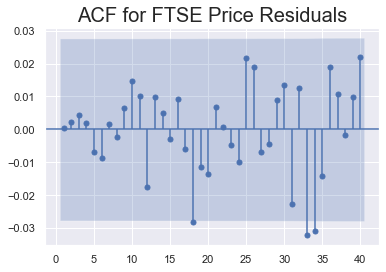

In [48]:
# only 3 lags are significant, the residual resemble white noise! The ARMA model predict well
df['residual2'] = result_56.resid
sgt.plot_acf(df.residual2, zero=False, lags=40)
plt.title('ACF for FTSE Price Residuals', size=20)
plt.show()

## ARMA for Returns vs ARMA for Prices

In [49]:
# Though you can preform ARMA on non-stationary data, but the likelihood and aic are much larger, so it's not as good as predicting stationary data
print('best ARMA model for Returns:', str(result_51.llf), str(result_51.aic))
print('best ARMA model for Prices:', str(result_56.llf), str(result_56.aic))

best ARMA model for Returns: -7889.3112829460715 15794.622565892143
best ARMA model for Prices: -27587.862948778184 55201.72589755637
